Problem statement (realistic):
Build a model to forecast daily AQI for Karachi to support air-quality alerts, planning, and health advisories.

Decision this data will support

1. Can we trust this dataset enough to train a forecasting model?

2. Is AQI behavior stable and learnable, or too noisy / broken?

3. Which features are actually predictive vs junk?

AQI EDA hypotheses

- H1: AQI data coverage is consistent over time (no long silent gaps)
- H2: Missing AQI values are NOT random and follow a pattern
- H3: AQI distribution is stable enough to be forecastable
- H4: Weather features correlate with AQI in expected directions
- H5: Extreme AQI spikes are rare and explainable, not data errors
- H6: Data leakage does not exist (no future information)


Data Source:
- AQI: External AQI API
- Weather: External Weather API

Storage:
- MongoDB
- Database: aqi_feature_store
- Collection: raw_aqi_weather_daily

Data Type:
- Raw daily aggregates (NOT user-modified)
- One row per city per day


In [10]:
import sys
import os

# Step 1: Set PROJECT_ROOT to one level above notebooks
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, PROJECT_ROOT)

print("Project root added to sys.path:", PROJECT_ROOT)

# Step 2: Imports after setting sys.path
from datetime import datetime, timedelta
from src.ingestion.merge_data import merge_historical_data

# Step 3: Replace with your AQICN token
token = "361cf32474f50ec4ff9f3f677392739e1bfd8384"

# Step 4: Fetch merged historical data
historical_df = merge_historical_data(city="karachi", token=token)

# Step 5: Quick sanity check
print("Merged historical data loaded. Shape:", historical_df.shape)
display(historical_df.head())


Project root added to sys.path: c:\Users\NAWAB AHMAD\aqi-forecasting-mlops
Project root added to sys.path: c:\Users\NAWAB AHMAD\aqi-forecasting-mlops\notebooks


[2026-01-28 03:03:58,194] [INFO] src.ingestion.merge_data - Fetching and merging historical data for karachi
[2026-01-28 03:03:58,195] [INFO] src.ingestion.station_resolver - Resolving AQICN station
[2026-01-28 03:03:59,446] [INFO] src.ingestion.station_resolver - Station resolved
[2026-01-28 03:03:59,448] [INFO] src.ingestion.openmeteo_historical_client - Fetching historical AQI from Open-Meteo
[2026-01-28 03:04:00,451] [INFO] src.ingestion.openmeteo_historical_client - Historical AQI normalized
[2026-01-28 03:04:00,746] [INFO] src.ingestion.openmeteo_weather_historical_client - Fetching historical weather from Open-Meteo
[2026-01-28 03:04:02,303] [INFO] src.ingestion.openmeteo_weather_historical_client - Historical weather normalized
[2026-01-28 03:04:02,643] [INFO] src.ingestion.merge_data - Merged historical data shape: (2904, 19)


Merged historical data loaded. Shape: (2904, 19)


,city_x,event_timestamp,source_x,ingested_at_x,pm25_pollutants,pm10_pollutants,no2_pollutants,so2_pollutants,o3_pollutants,co_pollutants,city_y,source_y,ingested_at_y,temperature_weather,humidity_weather,wind_speed_weather,wind_direction_weather,pressure_weather,precipitation_weather
0,karachi,2025-09-29 00:00:00+00:00,open-meteo,2026-01-27 22:04:00.445529+00:00,25.7,58.3,8.5,6.9,41.0,140.0,karachi,open-meteo-weather,2026-01-27 22:04:02.297170+00:00,25.9,97.0,10.4,324.0,1002.2,0.0
1,karachi,2025-09-29 01:00:00+00:00,open-meteo,2026-01-27 22:04:00.445529+00:00,25.8,55.1,14.7,8.4,35.0,295.0,karachi,open-meteo-weather,2026-01-27 22:04:02.297170+00:00,26.0,99.0,10.1,321.0,1002.5,0.0
2,karachi,2025-09-29 02:00:00+00:00,open-meteo,2026-01-27 22:04:00.445529+00:00,28.2,52.7,23.2,10.5,28.0,507.0,karachi,open-meteo-weather,2026-01-27 22:04:02.297170+00:00,26.0,97.0,9.3,326.0,1002.8,0.0
3,karachi,2025-09-29 03:00:00+00:00,open-meteo,2026-01-27 22:04:00.445529+00:00,31.7,49.8,27.9,12.9,35.0,665.0,karachi,open-meteo-weather,2026-01-27 22:04:02.297170+00:00,27.4,87.0,8.5,325.0,1003.0,0.0
4,karachi,2025-09-29 04:00:00+00:00,open-meteo,2026-01-27 22:04:00.445529+00:00,30.7,44.4,25.7,15.9,70.0,711.0,karachi,open-meteo-weather,2026-01-27 22:04:02.297170+00:00,30.2,71.0,8.6,331.0,1003.3,0.0


In [14]:
# --- Cell 1: Dataset sanity check ---
import pandas as pd

print("Shape:", historical_df.shape)
print("\nColumns:")
for col in historical_df.columns:
    print(f" - {col}")

print("\nDate range:")
print("Start:", historical_df["event_timestamp"].min())
print("End  :", historical_df["event_timestamp"].max())

print("\nDuplicate timestamps:",
      historical_df["event_timestamp"].duplicated().sum())

display(historical_df.head(3))
display(historical_df.tail(3))


Shape: (2904, 19)

Columns:
 - city_x
 - event_timestamp
 - source_x
 - ingested_at_x
 - pm25_pollutants
 - pm10_pollutants
 - no2_pollutants
 - so2_pollutants
 - o3_pollutants
 - co_pollutants
 - city_y
 - source_y
 - ingested_at_y
 - temperature_weather
 - humidity_weather
 - wind_speed_weather
 - wind_direction_weather
 - pressure_weather
 - precipitation_weather

Date range:
Start: 2025-09-29 00:00:00+00:00
End  : 2026-01-27 23:00:00+00:00

Duplicate timestamps: 0


,city_x,event_timestamp,source_x,ingested_at_x,pm25_pollutants,pm10_pollutants,no2_pollutants,so2_pollutants,o3_pollutants,co_pollutants,city_y,source_y,ingested_at_y,temperature_weather,humidity_weather,wind_speed_weather,wind_direction_weather,pressure_weather,precipitation_weather
0,karachi,2025-09-29 00:00:00+00:00,open-meteo,2026-01-27 22:04:00.445529+00:00,25.7,58.3,8.5,6.9,41.0,140.0,karachi,open-meteo-weather,2026-01-27 22:04:02.297170+00:00,25.9,97.0,10.4,324.0,1002.2,0.0
1,karachi,2025-09-29 01:00:00+00:00,open-meteo,2026-01-27 22:04:00.445529+00:00,25.8,55.1,14.7,8.4,35.0,295.0,karachi,open-meteo-weather,2026-01-27 22:04:02.297170+00:00,26.0,99.0,10.1,321.0,1002.5,0.0
2,karachi,2025-09-29 02:00:00+00:00,open-meteo,2026-01-27 22:04:00.445529+00:00,28.2,52.7,23.2,10.5,28.0,507.0,karachi,open-meteo-weather,2026-01-27 22:04:02.297170+00:00,26.0,97.0,9.3,326.0,1002.8,0.0


,city_x,event_timestamp,source_x,ingested_at_x,pm25_pollutants,pm10_pollutants,no2_pollutants,so2_pollutants,o3_pollutants,co_pollutants,city_y,source_y,ingested_at_y,temperature_weather,humidity_weather,wind_speed_weather,wind_direction_weather,pressure_weather,precipitation_weather
2901,karachi,2026-01-27 21:00:00+00:00,open-meteo,2026-01-27 22:04:00.451627+00:00,37.7,46.9,50.7,16.6,29.0,2123.0,karachi,open-meteo-weather,2026-01-27 22:04:02.303221+00:00,16.4,57.0,5.0,69.0,1019.7,0.0
2902,karachi,2026-01-27 22:00:00+00:00,open-meteo,2026-01-27 22:04:00.451627+00:00,39.1,44.2,45.9,15.8,27.0,1627.0,karachi,open-meteo-weather,2026-01-27 22:04:02.303221+00:00,15.4,60.0,8.2,75.0,1019.6,0.0
2903,karachi,2026-01-27 23:00:00+00:00,open-meteo,2026-01-27 22:04:00.451627+00:00,39.1,42.7,39.8,15.3,26.0,918.0,karachi,open-meteo-weather,2026-01-27 22:04:02.303221+00:00,14.5,62.0,7.5,37.0,1019.5,0.0


Time frequency check

In [15]:
# --- Cell 2: Temporal resolution check ---
time_diffs = (
    historical_df["event_timestamp"]
    .sort_values()
    .diff()
    .value_counts()
)

time_diffs.head(10)


event_timestamp
0 days 01:00:00    2903
Name: count, dtype: int64

What information is missing, and how bad is it?
- Do we have holes in the story, or is it complete?

In [16]:
# --- Cell 3: Missing data overview ---
missing_summary = (
    historical_df
    .isna()
    .sum()
    .sort_values(ascending=False)
)

missing_percent = (missing_summary / len(historical_df)) * 100

missing_df = pd.DataFrame({
    "missing_count": missing_summary,
    "missing_percent": missing_percent.round(2)
})

missing_df


,missing_count,missing_percent
city_x,0,0.0
city_y,0,0.0
pressure_weather,0,0.0
wind_direction_weather,0,0.0
wind_speed_weather,0,0.0
humidity_weather,0,0.0
temperature_weather,0,0.0
ingested_at_y,0,0.0
source_y,0,0.0
co_pollutants,0,0.0


Understand air pollution over time

- How bad is the air, and does it change in patterns?


PM2.5 over time

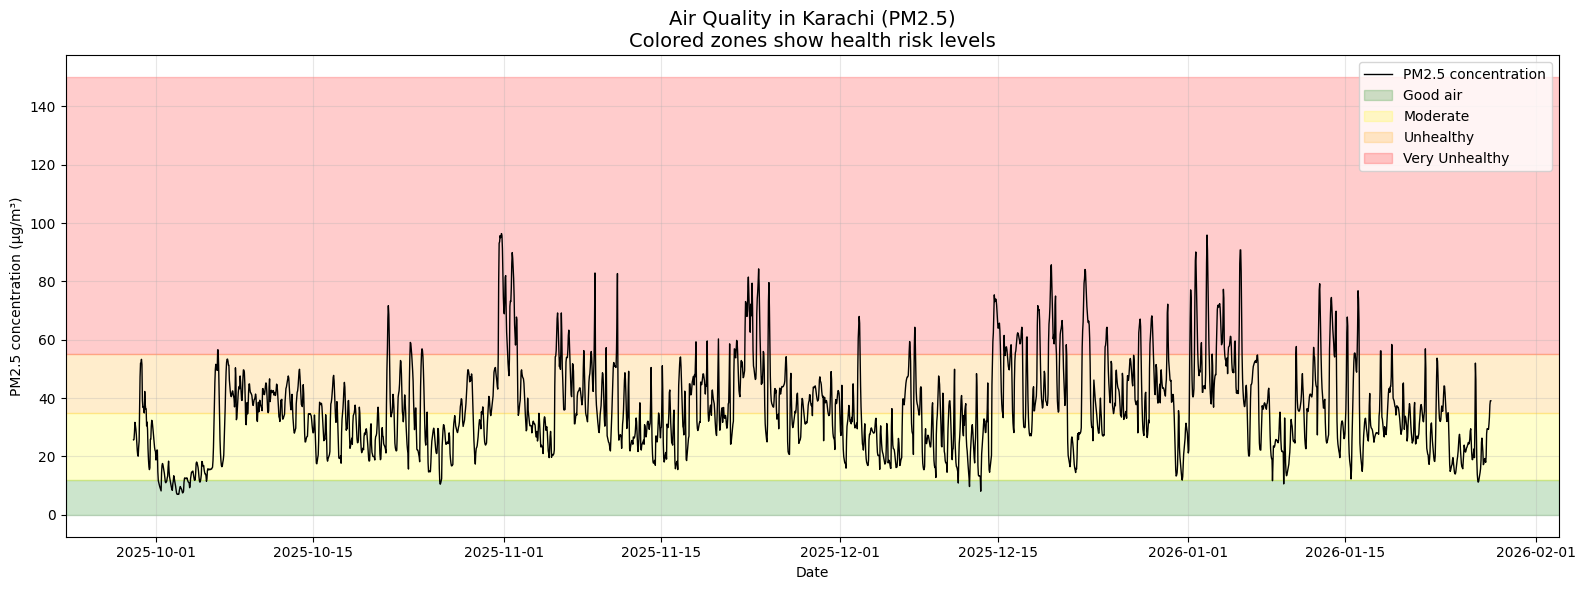

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

# Plot PM2.5 line
plt.plot(
    historical_df["event_timestamp"],
    historical_df["pm25_pollutants"],
    color="black",
    linewidth=1,
    label="PM2.5 concentration"
)

# Health bands (WHO inspired)
plt.axhspan(0, 12, alpha=0.2, label="Good air", color="green")
plt.axhspan(12, 35, alpha=0.2, label="Moderate", color="yellow")
plt.axhspan(35, 55, alpha=0.2, label="Unhealthy", color="orange")
plt.axhspan(55, 150, alpha=0.2, label="Very Unhealthy", color="red")

# Titles & labels (plain English)
plt.title(
    "Air Quality in Karachi (PM2.5)\n"
    "Colored zones show health risk levels",
    fontsize=14
)
plt.xlabel("Date")
plt.ylabel("PM2.5 concentration (µg/m³)")

plt.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Visualize daily average PM2.5 trends

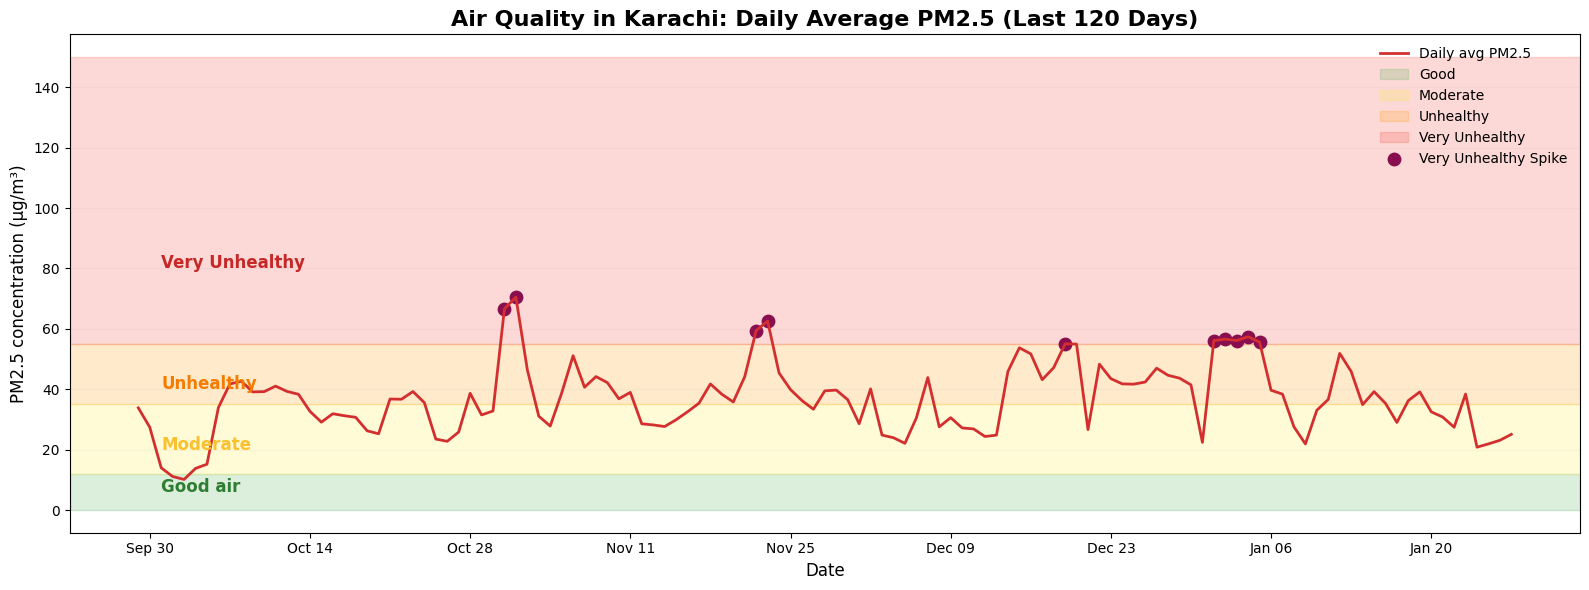

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Resample to daily average
daily_pm25 = historical_df.set_index("event_timestamp")["pm25_pollutants"].resample("D").mean()

plt.figure(figsize=(16, 6))

# Plot daily average PM2.5
plt.plot(
    daily_pm25.index,
    daily_pm25.values,
    color="#D32F2F",  # bright red for line
    linewidth=2,
    label="Daily avg PM2.5"
)

# Health bands
plt.axhspan(0, 12, color="#4CAF50", alpha=0.2, label="Good")
plt.axhspan(12, 35, color="#FFEB3B", alpha=0.2, label="Moderate")
plt.axhspan(35, 55, color="#FF9800", alpha=0.2, label="Unhealthy")
plt.axhspan(55, 150, color="#F44336", alpha=0.2, label="Very Unhealthy")

# Annotate health zones
plt.text(daily_pm25.index[2], 6, "Good air", color="#2E7D32", fontsize=12, weight="bold")
plt.text(daily_pm25.index[2], 20, "Moderate", color="#FBC02D", fontsize=12, weight="bold")
plt.text(daily_pm25.index[2], 40, "Unhealthy", color="#F57C00", fontsize=12, weight="bold")
plt.text(daily_pm25.index[2], 80, "Very Unhealthy", color="#C62828", fontsize=12, weight="bold")

# Highlight very unhealthy spikes
very_unhealthy = daily_pm25[daily_pm25 > 55]
plt.scatter(
    very_unhealthy.index,
    very_unhealthy.values,
    color="#880E4F",  # dark magenta for spikes
    s=80,
    marker="o",
    label="Very Unhealthy Spike"
)

# Titles and labels
plt.title("Air Quality in Karachi: Daily Average PM2.5 (Last 120 Days)", fontsize=16, weight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("PM2.5 concentration (µg/m³)", fontsize=12)

# Format x-axis to show month/day
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

plt.grid(axis="y", alpha=0.1)
plt.legend(loc="upper right", frameon=False)
plt.tight_layout()
plt.show()


# Multivariate Analysis: How Weather Affects Air Quality (PM2.5)

In the previous step, we visualized the **daily PM2.5 trends** in Karachi, along with health zones (Good, Moderate, Unhealthy, Very Unhealthy).  

In this step, we explore how **weather factors** and other pollutants relate to PM2.5:

- **Goal:** Identify which factors influence PM2.5 the most.
- **Why it matters:** Understanding these relationships helps us build a **better forecasting model**.
- **Method:** Compute and visualize the **correlation matrix** between PM2.5, other pollutants, and weather factors.

**What to look for in the heatmap:**

- **Strong positive correlation (red):** PM2.5 rises when this factor rises.
- **Strong negative correlation (blue):** PM2.5 drops when this factor rises.
- **Near zero correlation:** Factor likely has little direct impact.

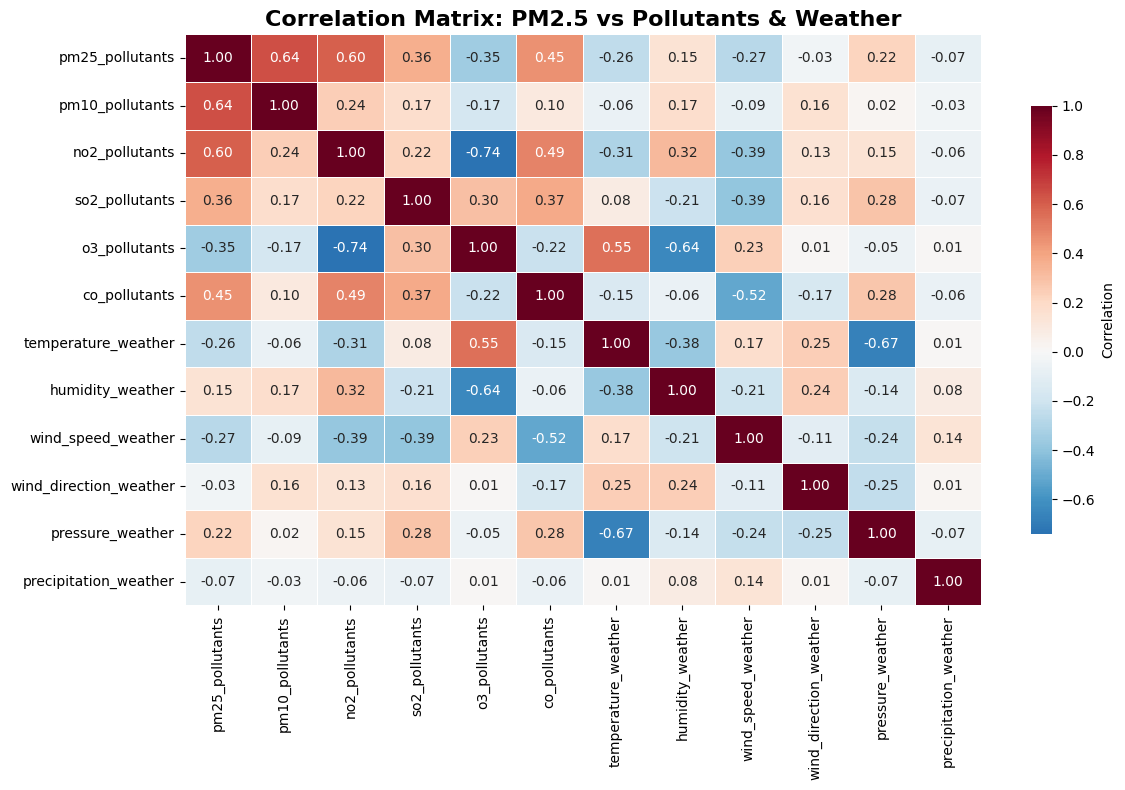

In [29]:
# --- Cell: Correlation Heatmap for PM2.5, pollutants, and weather ---

import seaborn as sns
import matplotlib.pyplot as plt

# Select only relevant numeric columns
numeric_cols = [
    "pm25_pollutants", "pm10_pollutants", "no2_pollutants",
    "so2_pollutants", "o3_pollutants", "co_pollutants",
    "temperature_weather", "humidity_weather",
    "wind_speed_weather", "wind_direction_weather",
    "pressure_weather", "precipitation_weather"
]

corr_df = historical_df[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_df,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75, "label": "Correlation"}
)
plt.title("Correlation Matrix: PM2.5 vs Pollutants & Weather", fontsize=16, weight="bold")
plt.tight_layout()
plt.show()


# Time-Lag Analysis: Understanding Past Effects on PM2.5

Air quality is **dynamic**: today's PM2.5 is influenced by:

- Yesterday's pollutant levels
- Past weather conditions (wind, temperature, humidity)
- Other external factors (traffic, industrial emissions)

Time-lag analysis helps us:

1. Identify **how many hours/days in the past** impact current PM2.5.
2. Determine which **lagged variables** should be included in the forecasting model.
3. Explain trends to non-technical audiences by showing **past → present relationships**.

**How to read the chart**:

- Positive correlation at lag = 1 day → yesterday's PM2.5 predicts today's PM2.5.
- Negative correlation at some lags → inverse effect (e.g., wind speed reduces PM2.5 the next day).
- Near-zero → little influence at that lag.


In [32]:
# --- Cell 1: Compute lag correlations for PM2.5 ---

import pandas as pd

# We already have historical_df in memory
pm25_series = historical_df.set_index("event_timestamp")["pm25_pollutants"]

# Maximum lag to check (in days)
max_lag = 7  # last 7 days

# Compute correlation of each lag with today
lag_correlations = {}
for lag in range(1, max_lag + 1):
    # Shift series by 'lag' days
    shifted = pm25_series.shift(lag*24)  # 24 hours per day
    # Compute correlation
    corr = pm25_series.corr(shifted)
    lag_correlations[lag] = corr

# Convert to DataFrame for plotting
lag_corr_df = pd.DataFrame({
    "Lag (days)": list(lag_correlations.keys()),
    "Correlation": list(lag_correlations.values())
})

lag_corr_df


,Lag (days),Correlation
0,1,0.537098
1,2,0.358957
2,3,0.272449
3,4,0.226354
4,5,0.210123
5,6,0.144726
6,7,0.149499


C:\Users\NAWAB AHMAD\AppData\Local\Temp\ipykernel_29516\1172556458.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


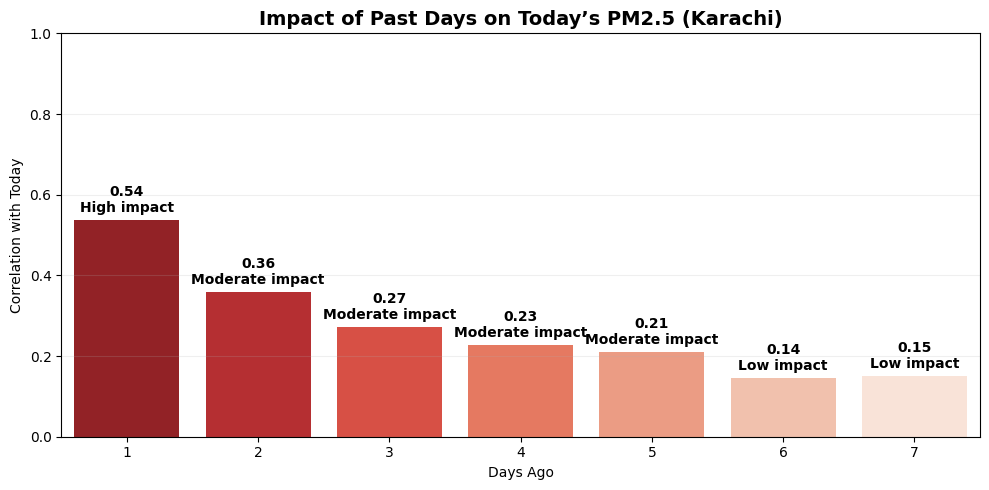

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))

# Bar plot
sns.barplot(
    x="Lag (days)", 
    y="Correlation", 
    data=lag_corr_df, 
    palette="Reds_r"
)

# Titles & labels
plt.title("Impact of Past Days on Today’s PM2.5 (Karachi)", fontsize=14, weight="bold")
plt.xlabel("Days Ago")
plt.ylabel("Correlation with Today")
plt.ylim(0,1)
plt.grid(axis="y", alpha=0.2)

# Annotate bars with correlation and impact explanation
for idx, row in lag_corr_df.iterrows():
    corr_value = row["Correlation"]
    # Define simple layman-friendly impact label
    if corr_value > 0.4:
        impact = "High impact"
    elif corr_value > 0.2:
        impact = "Moderate impact"
    else:
        impact = "Low impact"
    
    plt.text(
        row["Lag (days)"]-1, corr_value + 0.02, 
        f"{corr_value:.2f}\n{impact}", 
        ha='center', 
        weight="bold",
        fontsize=10,
        color="#000000"
    )

plt.tight_layout()
plt.show()


PM2.5 Pattern by Day of Week

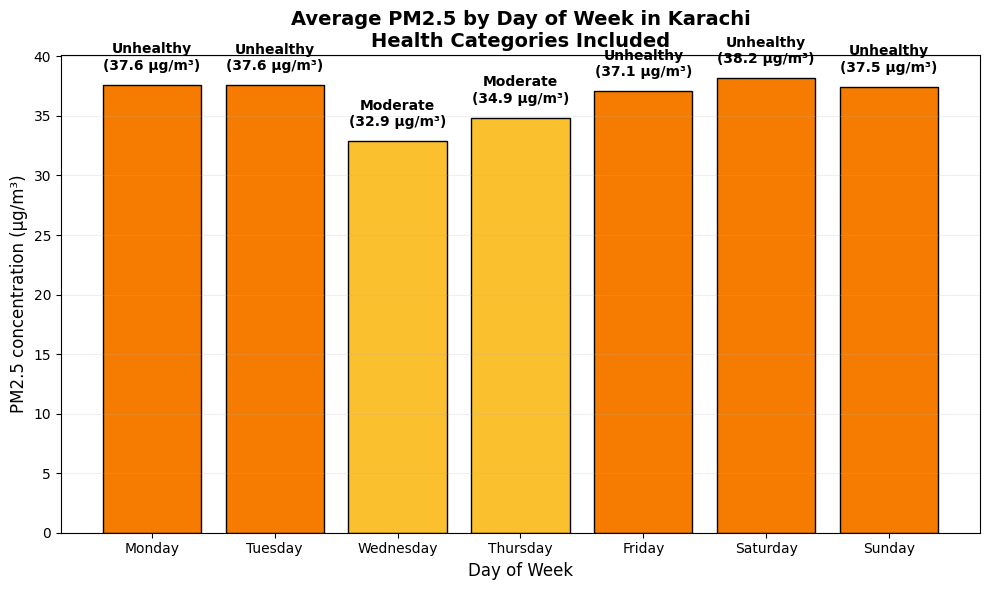

In [36]:
# --- Step 1: PM2.5 Pattern by Day of Week (Layman-Friendly Version) ---

import matplotlib.pyplot as plt

# Map PM2.5 levels to health categories (WHO inspired)
def pm25_category(value):
    if value <= 12:
        return "Good air"
    elif value <= 35:
        return "Moderate"
    elif value <= 55:
        return "Unhealthy"
    else:
        return "Very Unhealthy"

# Extract day of week
historical_df['day_of_week'] = historical_df['event_timestamp'].dt.day_name()

# Compute average PM2.5 per day
avg_pm25_by_day = historical_df.groupby('day_of_week')['pm25_pollutants'].mean()

# Order days correctly
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_pm25_by_day = avg_pm25_by_day.reindex(days_order)

# Define color mapping
def pm25_color(value):
    if value <= 12:
        return "#2E7D32"  # dark green
    elif value <= 35:
        return "#FBC02D"  # yellow
    elif value <= 55:
        return "#F57C00"  # orange
    else:
        return "#C62828"  # red

colors = [pm25_color(v) for v in avg_pm25_by_day.values]

# Plot
plt.figure(figsize=(10,6))
bars = plt.bar(avg_pm25_by_day.index, avg_pm25_by_day.values, color=colors, edgecolor="#000000")

# Annotate each bar with health label
for bar, value in zip(bars, avg_pm25_by_day.values):
    height = bar.get_height()
    category = pm25_category(value)
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        height + 1, 
        f"{category}\n({value:.1f} µg/m³)", 
        ha='center', va='bottom', fontsize=10, weight='bold'
    )

plt.title("Average PM2.5 by Day of Week in Karachi\nHealth Categories Included", fontsize=14, weight='bold')
plt.ylabel("PM2.5 concentration (µg/m³)", fontsize=12)
plt.xlabel("Day of Week", fontsize=12)
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()


Average PM2.5 by Hour of Day

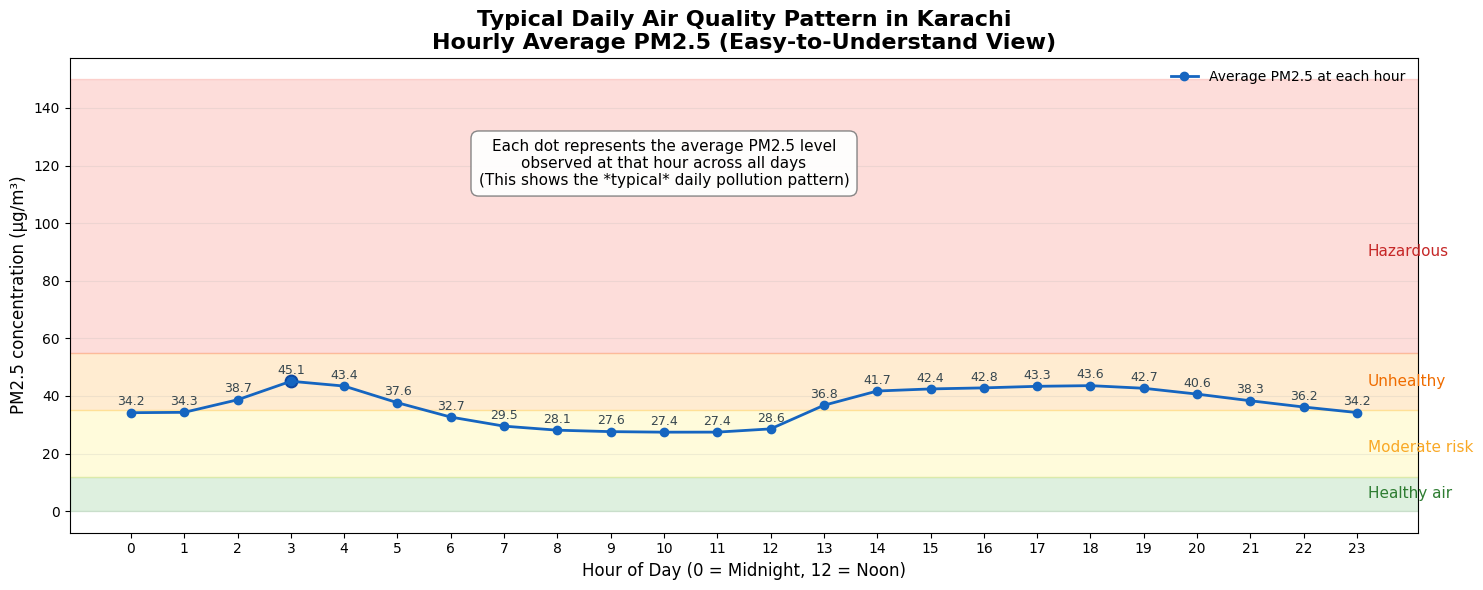

In [73]:
import matplotlib.pyplot as plt

# Prepare hourly averages
historical_df["hour"] = historical_df["event_timestamp"].dt.hour
hourly_avg = historical_df.groupby("hour")["pm25_pollutants"].mean()

plt.figure(figsize=(15, 6))

# Main line + dots
plt.plot(
    hourly_avg.index,
    hourly_avg.values,
    marker="o",
    linewidth=2,
    color="#1565C0",
    label="Average PM2.5 at each hour"
)

# Health bands
plt.axhspan(0, 12, color="#4CAF50", alpha=0.18)
plt.axhspan(12, 35, color="#FFEB3B", alpha=0.18)
plt.axhspan(35, 55, color="#FF9800", alpha=0.18)
plt.axhspan(55, 150, color="#F44336", alpha=0.18)

# Health labels (placed safely on right side)
plt.text(23.2, 6, "Healthy air", color="#2E7D32", fontsize=11, va="center")
plt.text(23.2, 22, "Moderate risk", color="#F9A825", fontsize=11, va="center")
plt.text(23.2, 45, "Unhealthy", color="#EF6C00", fontsize=11, va="center")
plt.text(23.2, 90, "Hazardous", color="#C62828", fontsize=11, va="center")

# Highlight peak hour (visual cue only)
peak_hour = hourly_avg.idxmax()
peak_value = hourly_avg.max()
plt.scatter(peak_hour, peak_value, color="#0D47A1", s=80)

# Explanatory text box (clean & readable)
plt.text(
    10,
    hourly_avg.min() - (hourly_avg.max() * - 1.9),
    "Each dot represents the average PM2.5 level\n"
    "observed at that hour across all days\n"
    "(This shows the *typical* daily pollution pattern)",
    fontsize=11,
    ha="center",
    bbox=dict(
        boxstyle="round,pad=0.5",
        facecolor="white",
        edgecolor="gray",
        alpha=0.95
    )
)

# Add numeric labels above each dot (layman-friendly)
for hour, value in hourly_avg.items():
    plt.text(
        hour,
        value + 1.5,              # slight offset above dot
        f"{value:.1f}",            # one decimal for clarity
        ha="center",
        va="bottom",
        fontsize=9,
        color="#37474F"
    )


# Titles & labels
plt.title(
    "Typical Daily Air Quality Pattern in Karachi\n"
    "Hourly Average PM2.5 (Easy-to-Understand View)",
    fontsize=16,
    weight="bold"
)
plt.xlabel("Hour of Day (0 = Midnight, 12 = Noon)", fontsize=12)
plt.ylabel("PM2.5 concentration (µg/m³)", fontsize=12)

plt.xticks(range(0, 24))
plt.grid(axis="y", alpha=0.2)
plt.legend(frameon=False)

plt.tight_layout()
plt.show()


Correlation with PM2.5

In [62]:
import pandas as pd

# Select only numeric weather + PM2.5
features = [
    "pm25_pollutants",
    "temperature_weather",
    "humidity_weather",
    "wind_speed_weather",
    "pressure_weather",
    "precipitation_weather"
]

corr_df = historical_df[features].corr()

# Sort by impact on PM2.5
pm25_corr = (
    corr_df["pm25_pollutants"]
    .drop("pm25_pollutants")
    .sort_values(key=abs, ascending=False)
)

pm25_corr


wind_speed_weather      -0.274337
temperature_weather     -0.256761
pressure_weather         0.220244
humidity_weather         0.146495
precipitation_weather   -0.074718
Name: pm25_pollutants, dtype: float64

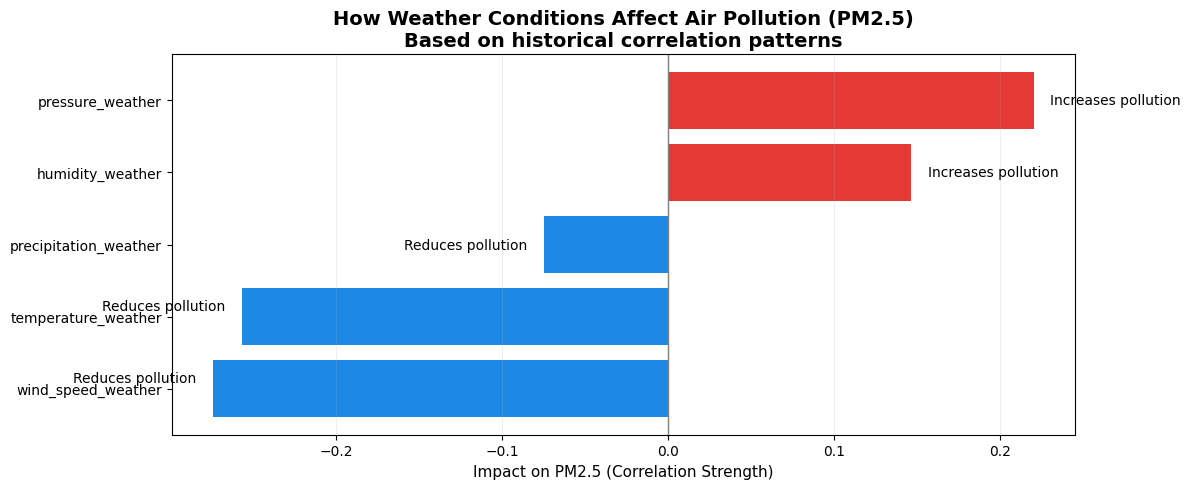

In [70]:
import matplotlib.pyplot as plt
import pandas as pd

# Correlation results (already computed by you)
impact_df = pd.DataFrame({
    "Factor": [
        "wind_speed_weather",
        "temperature_weather",
        "pressure_weather",
        "humidity_weather",
        "precipitation_weather"
    ],
    "Impact": [
        -0.274337,
        -0.256761,
        0.220244,
        0.146495,
        -0.074718
    ]
}).sort_values("Impact")

plt.figure(figsize=(12, 5))

# Horizontal bars
bars = plt.barh(
    impact_df["Factor"],
    impact_df["Impact"],
    color=["#1E88E5" if v < 0 else "#E53935" for v in impact_df["Impact"]]
)

# Zero reference line
plt.axvline(0, color="gray", linewidth=1)

# --- TEXT LABELS (collision-safe) ---
for i, (bar, value) in enumerate(zip(bars, impact_df["Impact"])):
    label = "Reduces pollution" if value < 0 else "Increases pollution"

    # Small vertical offset ONLY for overlapping bars
    y_offset = 0
    if impact_df["Factor"].iloc[i] in ["wind_speed_weather", "temperature_weather"]:
        y_offset = 0.15 if value < 0 else -0.15

    plt.text(
        value + (0.01 if value > 0 else -0.01),
        bar.get_y() + bar.get_height()/2 + y_offset,
        label,
        va="center",
        ha="left" if value > 0 else "right",
        fontsize=10,
        color="black"
    )

# Titles & labels
plt.title(
    "How Weather Conditions Affect Air Pollution (PM2.5)\n"
    "Based on historical correlation patterns",
    fontsize=14,
    weight="bold"
)
plt.xlabel("Impact on PM2.5 (Correlation Strength)", fontsize=11)

# Clean look
plt.grid(axis="x", alpha=0.2)
plt.tight_layout()
plt.show()


Visualize Daily PM2.5 Trends (line chart with rolling average)

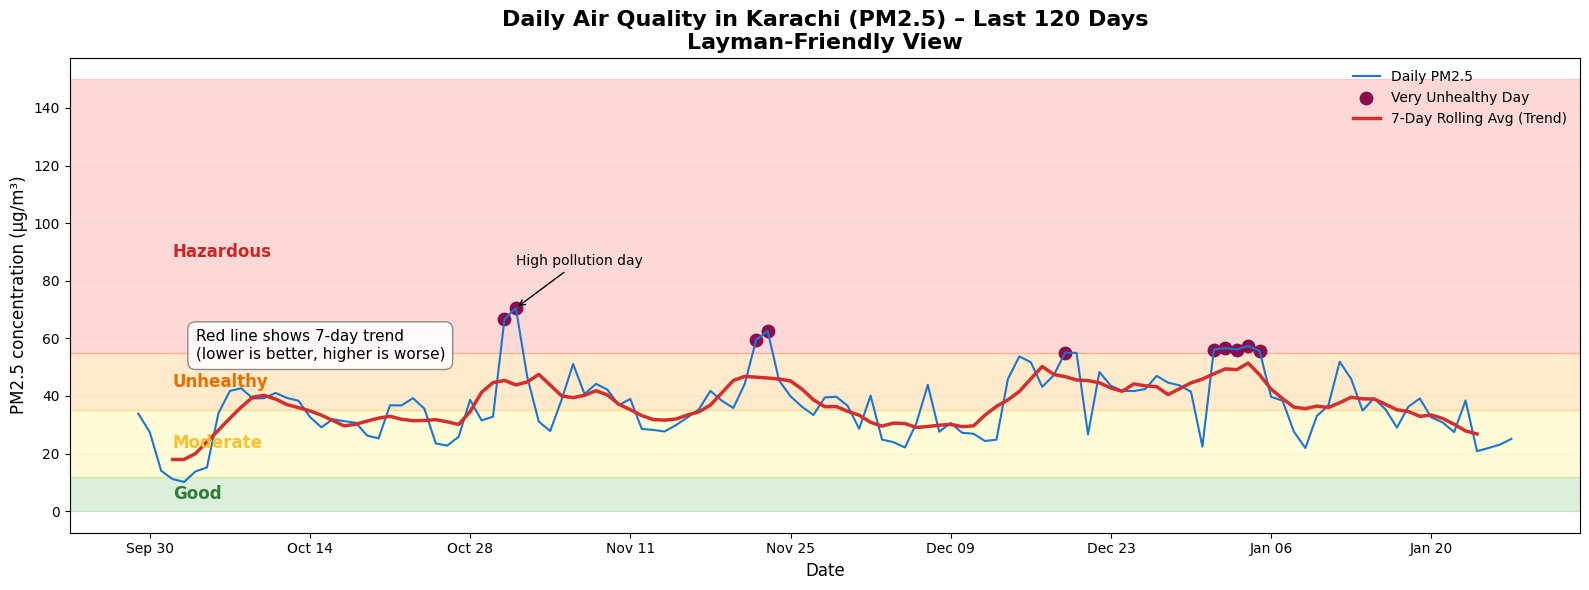

In [76]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Prepare daily average
historical_df["date"] = historical_df["event_timestamp"].dt.date
daily_avg = historical_df.groupby("date")["pm25_pollutants"].mean()

# 7-day rolling average
rolling_avg = daily_avg.rolling(window=7, center=True).mean()

plt.figure(figsize=(16, 6))

# Health bands (with labels inside each band)
plt.axhspan(0, 12, color="#4CAF50", alpha=0.2)
plt.text(daily_avg.index[3], 6, "Good", color="#2E7D32", fontsize=12, weight="bold", va="center")
plt.axhspan(12, 35, color="#FFEB3B", alpha=0.2)
plt.text(daily_avg.index[3], 23.5, "Moderate", color="#FBC02D", fontsize=12, weight="bold", va="center")
plt.axhspan(35, 55, color="#FF9800", alpha=0.2)
plt.text(daily_avg.index[3], 45, "Unhealthy", color="#EF6C00", fontsize=12, weight="bold", va="center")
plt.axhspan(55, 150, color="#F44336", alpha=0.2)
plt.text(daily_avg.index[3], 90, "Hazardous", color="#C62828", fontsize=12, weight="bold", va="center")

# Plot daily average
plt.plot(
    daily_avg.index,
    daily_avg.values,
    color="#1976D2",
    linewidth=1.5,
    label="Daily PM2.5"
)

# Highlight very unhealthy spikes
very_unhealthy = daily_avg[daily_avg > 55]
plt.scatter(
    very_unhealthy.index,
    very_unhealthy.values,
    color="#880E4F",
    s=80,
    marker="o",
    label="Very Unhealthy Day"
)

# Plot 7-day rolling average
plt.plot(
    rolling_avg.index,
    rolling_avg.values,
    color="#D32F2F",
    linewidth=2.5,
    label="7-Day Rolling Avg (Trend)"
)

# Text box for rolling average explanation
plt.text(
    rolling_avg.index[5],
    max(daily_avg)*0.75,
    "Red line shows 7-day trend\n(lower is better, higher is worse)",
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray", alpha=0.9)
)

# Annotate a peak spike
peak_date = very_unhealthy.idxmax()
peak_value = very_unhealthy.max()
plt.annotate(
    "High pollution day",
    xy=(peak_date, peak_value),
    xytext=(peak_date, peak_value+15),
    arrowprops=dict(facecolor="gray", arrowstyle="->"),
    fontsize=10
)

# Titles & labels
plt.title(
    "Daily Air Quality in Karachi (PM2.5) – Last 120 Days\nLayman-Friendly View",
    fontsize=16, weight="bold"
)
plt.xlabel("Date", fontsize=12)
plt.ylabel("PM2.5 concentration (µg/m³)", fontsize=12)

# X-axis formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

plt.grid(axis="y", alpha=0.1)
plt.legend(loc="upper right", frameon=False)
plt.tight_layout()
plt.show()


Pearson correlations between PM2.5 and weather features (temperature, wind, humidity, pressure, precipitation)

In [77]:
# Select only weather columns + PM2.5
weather_features = ["temperature_weather", "humidity_weather", "wind_speed_weather", 
                    "wind_direction_weather", "pressure_weather", "precipitation_weather"]

correlations = historical_df[weather_features + ["pm25_pollutants"]].corr()["pm25_pollutants"].drop("pm25_pollutants")

print("Correlation of PM2.5 with weather features:\n")
display(correlations.sort_values(ascending=False))


Correlation of PM2.5 with weather features:



pressure_weather          0.220244
humidity_weather          0.146495
wind_direction_weather   -0.034122
precipitation_weather    -0.074718
temperature_weather      -0.256761
wind_speed_weather       -0.274337
Name: pm25_pollutants, dtype: float64

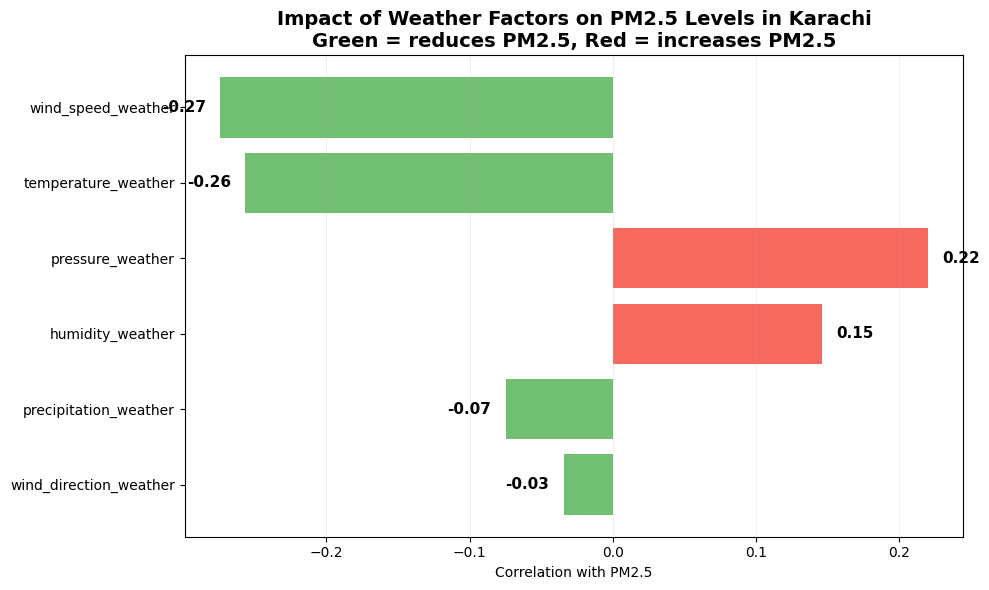

In [104]:
import matplotlib.pyplot as plt

# Correlations (already calculated)
correlations = {
    "wind_speed_weather": -0.274337,
    "temperature_weather": -0.256761,
    "pressure_weather": 0.220244,
    "humidity_weather": 0.146495,
    "precipitation_weather": -0.074718,
    "wind_direction_weather": -0.034122
}

# Convert to DataFrame for easy sorting
import pandas as pd
corr_df = pd.DataFrame.from_dict(correlations, orient="index", columns=["correlation"])
corr_df["abs_corr"] = corr_df["correlation"].abs()
corr_df = corr_df.sort_values("abs_corr", ascending=True)  # smallest at bottom, largest at top

# Color mapping: green for negative (reduces PM2.5), red for positive (increases)
colors = ["#4CAF50" if x < 0 else "#F44336" for x in corr_df["correlation"]]

plt.figure(figsize=(10, 6))
bars = plt.barh(corr_df.index, corr_df["correlation"], color=colors, alpha=0.8)

# Add correlation numbers at the end of bars
for bar in bars:
    width = bar.get_width()
    plt.text(
        x=width + (0.01 if width > 0 else -0.01),
        y=bar.get_y() + bar.get_height()/2,
        s=f"{width:.2f}",
        va="center",
        ha="left" if width > 0 else "right",
        fontsize=11,
        weight="bold"
    )

# Titles & legend
plt.title(
    "Impact of Weather Factors on PM2.5 Levels in Karachi\n"
    "Green = reduces PM2.5, Red = increases PM2.5",
    fontsize=14,
    weight="bold"
)
plt.xlabel("Correlation with PM2.5")
plt.grid(axis="x", alpha=0.2)
plt.tight_layout()
plt.show()
